# Estimate Signal-to-Noise ratio $S/N$

To estimate the $S/N$, ideally you would know the *True* signal, subtract it from the observed signals, and then examine the distribution of the per-pixel residuals.  The residuals would form a Bell curve, and the width $\sigma$ of this Normal Distribution would represent the typical per-pixel uncertainty.  In practice, we never know the *True* signal.  We can approximate the signal by saying that the underlying signal likely varies *smoothly*, whereas noise jumps around from pixel-to-pixel.  In this tutorial we should how to estimate $S/N$ with Gaussian Process regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from muler.igrins import IGRINSSpectrum
import celerite2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def plot_prediction(gp):
    plt.figure(figsize=(14,4))
    plt.plot(λ, f, label="data")

    if gp:
        mu, variance = gp.predict(f-1, t=λ, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(λ, 1+mu, label="prediction")
        plt.fill_between(λ, 1+mu - sigma, 1+mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("$\lambda \;(\AA)$")
    plt.ylabel("flux")
    plt.ylim(0.6, 1.4)
    plt.legend()

Read in the spectrum with `muler`.

In [3]:
spec = IGRINSSpectrum(file='../../tests/data/SDCH_20201202_0059.spec_a0v.fits')

spec = spec.remove_nans().normalize()[200:]

λ = spec.wavelength.value
f = spec.flux.value
unc = spec.uncertainty.array
snr = f / unc

In [ ]:
smooth = spec.smooth_spectrum()

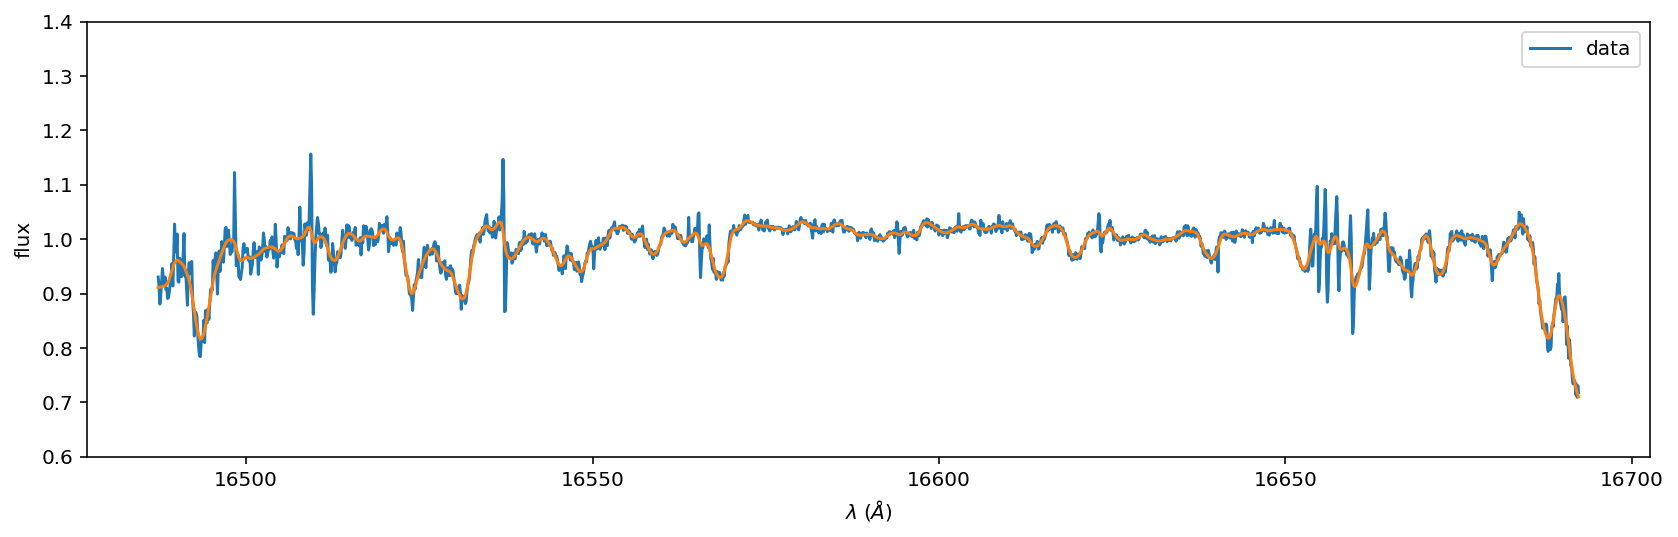

In [5]:
plot_prediction(None)
plt.plot(smooth.wavelength.value, smooth.flux.value)

In [6]:
median_snr = np.median(snr)
low_snr = snr<0.15*median_snr

In [7]:
λ = λ[~low_snr]
f = f[~low_snr]
unc = unc[~low_snr]

We can follow the [celerite2 tutorial](https://celerite2.readthedocs.io/en/latest/tutorials/first/) to set up a GP model.

In [8]:
from celerite2 import terms

In [9]:
# Non-periodic component
term1 = terms.SHOTerm(sigma=0.03, rho=15.0, Q=0.5)
kernel = term1

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(λ)

print("Initial log likelihood: {0}".format(gp.log_likelihood(f-1.0)))

Initial log likelihood: -2785142.3223185576


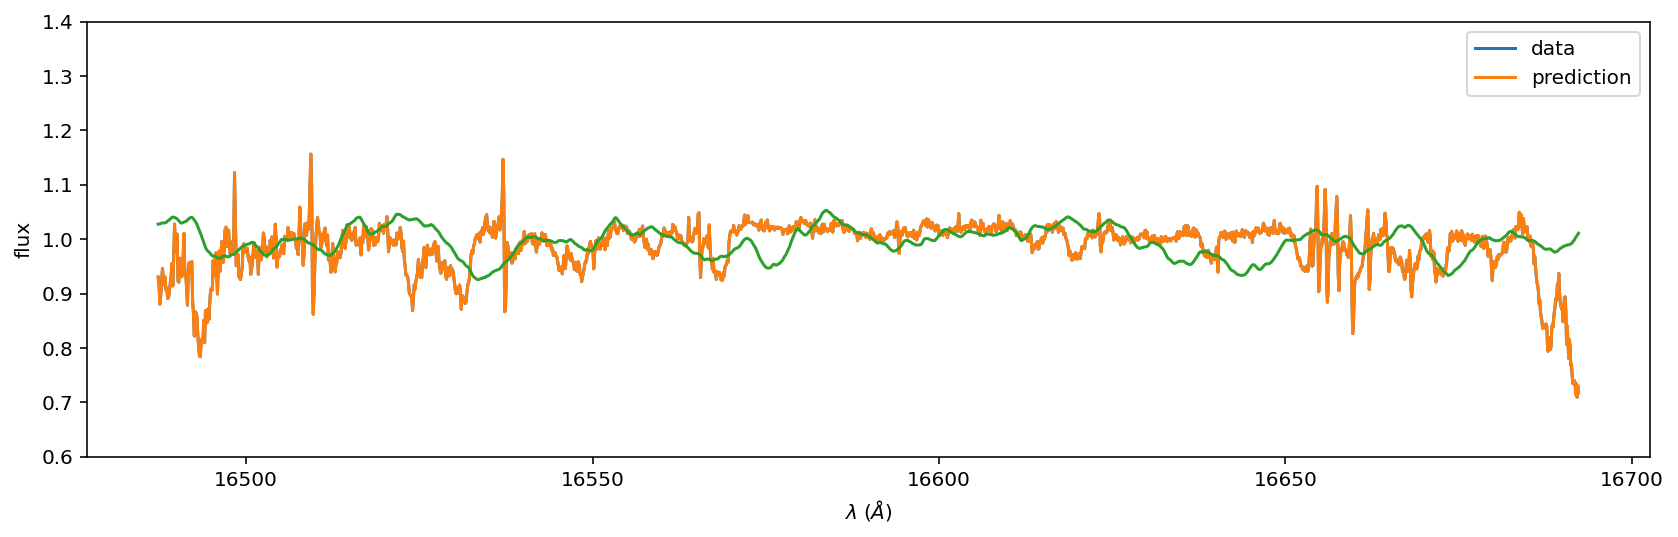

In [10]:
plot_prediction(gp)
plt.plot(λ, gp.sample()+1)

In [12]:
from scipy.optimize import minimize

In [17]:
mu = opt_gp.predict(f-1, t=λ)
residual = f - mu -1
residual_in_sigma = residual / unc

sigma_vector = np.arange(-20, 20, 0.1)

In [18]:
from scipy.stats import norm

In [19]:
pdf = norm().pdf(sigma_vector)

(0.003, 1.0)

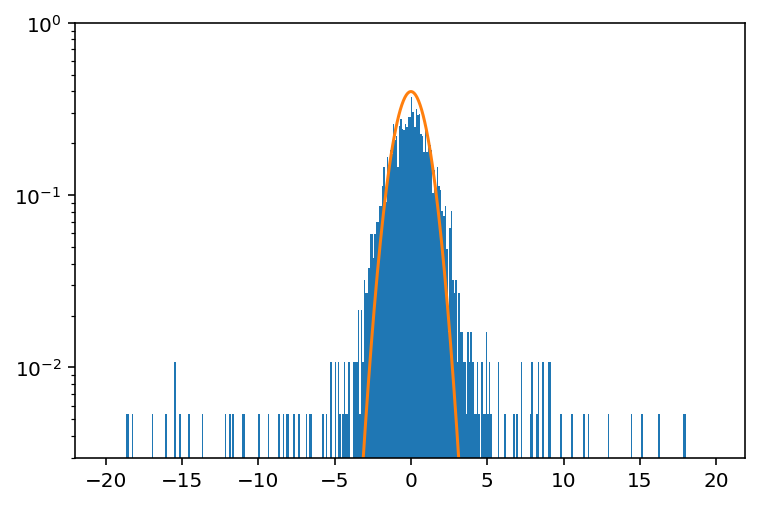

In [20]:
plt.hist(residual_in_sigma, bins=sigma_vector, density=True);
plt.plot(sigma_vector, pdf)
plt.yscale('log')
plt.ylim(3e-3, 1e0)

In [21]:
outliers = np.abs(residual_in_sigma) > 5

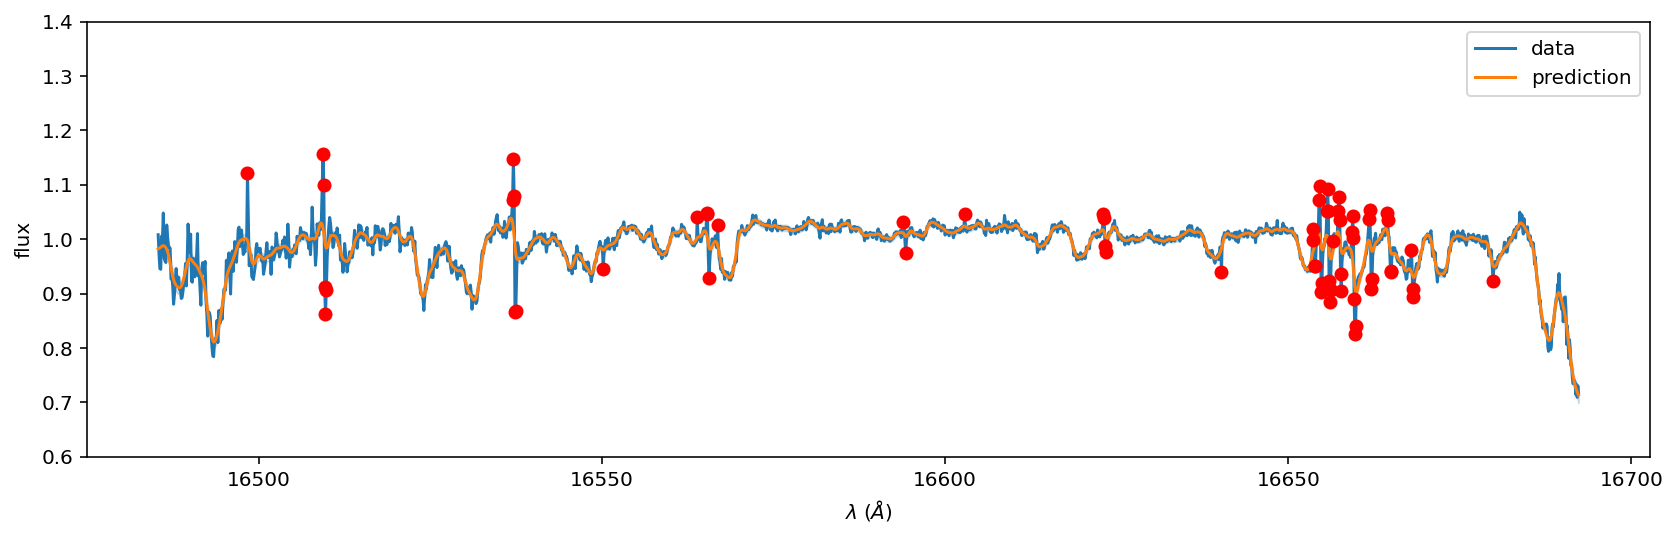

In [22]:
plot_prediction(opt_gp)
plt.plot(λ[outliers], f[outliers], 'ro')

We found the outliers!